In [1]:
import TempCompleteFunctions as tpc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## To Do:
- Add data slicing to GW2dAnalysis
- Create methods/functions for spectrograms 

In [2]:
class GWAnalysis:
    '''
    Tool for analizing gravitational waves
    '''
    
    def __init__(self, dataPath, dataFile, dataColumns, timeSample = 0, timeStep = 5, tBounce = 0, nVerts = 5):
        '''
        dataPath: relative path to the main repository of the data/program
        dataFile: file name
        dataColumns: list of columns numbers that reference the data in the file
        timeSample: range of times to work through when analizing data, set as list [start time index, end time index]
        timeStep: time step to take when analizing data
        tBounce: post bounce time [s]
        nVerts: number of vertecies/points to use when interpreting angle information
        '''
        #Import neccesary packages to the correct namespace
        import numpy as np
        import TempCompleteFunctions as tpc
        import matplotlib.pyplot as plt
        import matplotlib.colors as colors
        
        if isinstance(nVerts, complex) == False:
            raise ValueError('nVerts must be entered as a complex number (ex: 10j), please enter a new value!')
        
        if nVerts.imag < 10j.imag:
            raise ValueError('nVerts can not be less than 10, please enter a new value!')
        
        #Set attributes
        self.dataPath = dataPath
        self.dataFile = dataFile
        self.dataColumns = dataColumns
        self.timeSample = timeSample
        self.timeStep = timeStep
        self.tBounce = tBounce
        self.nVerts = nVerts
        
    def update_TimeStep(self, timeStep):
        '''
        Update the value for timeStep
        
        timeStep: time step to take when analizing data
        '''
        self.timeStep = timeStep
    
    def update_nVerts(self, nVerts):
        '''
        Update the value for nVerts
        
        nVerts: number of vertecies/points to use when interpreting angle information,
                must be complex number 10 or greater
        '''
        #Check if value is complex
        if isinstance(nVerts, complex) == False:
            raise ValueError('nVerts must be entered as a complex number (ex: 10j), please enter a new value!')
        
        #Check if value is greater than or equal to 10j
        if nVerts.imag < 10j.imag:
            raise ValueError('nVerts can not be less than 10, please enter a new value!')
        
        self.nVerts = nVerts
    
    def update_timeSample(self, timeSample):
        '''
        Update the value for timeSample
        
        timeSample: range of times to work through when analizing data, set as list [start time, end time]
        '''
        self.timeSample = timeSample
        
    def load_QuadData(self, dataFolder = 0):
        '''
        Load and store data
        
        dataFolder: name of folder where data is stored
        '''
        #Check if the data file is stored in a folder or not, create the correct filePath
        if dataFolder != 0:
            filePath = self.dataPath + '\\' + dataFolder + '\\' + self.dataFile
        
        else:
            filePath = self.dataPath + '\\' + self.dataFile
        
        #Load in the data associated with the file and the specified columns
        t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = np.loadtxt(filePath, usecols = (self.dataColumns), unpack=True)
    
        self.rawTime = t
        self.rawData = np.array([Qxx,Qyy,Qxy,Qxz,Qyz,Qzz])
        
        #Update timeSample
        self.update_timeSample(np.arange(0,len(self.rawTime),self.timeStep))
        
    def set_rawDataHeaders(self, dataHeaders):
        '''
        Save headers for the raw data
        
        dataHeaders: list of headers equal in length to rawData
        '''
        self.dataHeaders = dataHeaders
        
    def strain3dSurfMaxValue(self, polarization):
        '''
        Get the 
        
        polarization: setting for which polarization to use, (0 = cross, 1 = plus, 2 = norm diff)
        '''
        #theta - altitudinal angle [radians]
        #phi   - azimuthal angle  [radians]
        thetaPhi = np.mgrid[0:np.pi:self.nVerts, 0:2*np.pi:self.nVerts]
        
        analysisTime = self.rawTime[self.timeSample]
        
        QddotXX = tpc.cenDiff(analysisTime,self.rawData[0][self.timeSample])
        QddotYY = tpc.cenDiff(analysisTime,self.rawData[1][self.timeSample])
        QddotXY = tpc.cenDiff(analysisTime,self.rawData[2][self.timeSample])
        QddotXZ = tpc.cenDiff(analysisTime,self.rawData[3][self.timeSample])
        QddotYZ = tpc.cenDiff(analysisTime,self.rawData[4][self.timeSample])
        QddotZZ = tpc.cenDiff(analysisTime,self.rawData[5][self.timeSample])
        
        if polarization == 0: 
            hVals = tpc.crossGeneral(thetaPhi[0],thetaPhi[1],analysisTime,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,CenDiff=False)

        elif polarization == 1:
            hVals = tpc.plusGeneral(thetaPhi[0],thetaPhi[1],analysisTime,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,QddotZZ,CenDiff=False)

        elif polarization == 2:
            hVals = tpc.normDiffGeneral(thetaPhi[0],thetaPhi[1],analysisTime,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,QddotZZ,CenDiff=False)

        else:
            print('Correct the value given for polarization (0 = cross, 1 = plus, 2 = norm diff)!!')
            return()
        
        '''
        Get confirmation for these conversions
        '''
        xSph = hVals * np.sin(thetaPhi[1]) * np.cos(thetaPhi[0])
        ySph = hVals * np.sin(thetaPhi[1]) * np.sin(thetaPhi[0])
        zSph = hVals * np.cos(thetaPhi[1])

        return(xSph,ySph,zSph,hVals)
           
    def GW2dAnalysis(self, polarization, graphSize = [10,10], xlim = [0,0], ylim = [0,0]):
        '''
        
        polarization: setting for which polarization to use, (0 = cross, 1 = plus, 2 = norm diff)
        graphSize: size of the image produced, list [width, height]
        xlim: x-axis limits for the graph, list [left bound, right bound]
        ylim: y-axis limits for the graph, list [lower bound, upper bound]
        '''
        #Data acquisition
        tempH = self.strain3dSurfMaxValue(polarization)[3] #Only grab hVals

        tempH = tempH[:,4,0]# simplification/generalization of tempH = tempH.reshape(len(self.timeSample))
        
        #Plotting
        fig, ax = plt.subplots(1)
        fig.set_size_inches(graphSize[0],graphSize[1])

        ax.plot(self.rawTime[self.timeSample]-self.tBounce, tempH) 
        ax.axvline(0, c='black', label = 'Post Bounce Time: ' + str(self.tBounce), alpha = 0.5)

        #Check if the limits are set by the user or not
        if xlim != [0,0]:
            ax.set_xlim(xlim)
        else:
            ax.set_xlim([-0.05,self.rawTime[-1]-self.tBounce+0.05])

        if ylim != [0,0]:
            ax.set_ylim(ylim)
            
        ax.set_title('GW Strain Vs Post Bounce Time ('+  self.dataFile +')')
        ax.set_xlabel('Time (s)')
        ax.legend()
        
        attachedDataFR = np.loadtxt('RawDataFiles/s40_fr_GW_short.txt')

        ax.plot(attachedDataFR[:,0], attachedDataFR[:,1]) 

        ax.set_xlabel('Time (s)')
        
        
    def genScatterPlot(self, cord_XYZ_Set, prefix, path, title, rotationArray, analysisTime, norm = False, dataSlice = (0,2), alpha = 0.8): 
        '''
        Check if timeIt is needed here
            Check to see if its the same length as xSet
            
        cord_XYZ_Set: array of cordinates x,y,z with shape [3,n] where n is the number of samples
        prefix: generated image filename prefix
        path: path from working directory to where generated image files should be stored (end with /)
        title: title of the generated plot
        rotationArray: array of degrees to rotate through when generating the images for the animation
        analysisTime: 
        norm: conditional, whether to normalize the plotted data or not
        dataSlice: tuple indicating what times (between the values) from the data will be plotted
        alpha: alpha level to plot data points at
        '''

        #Unpack cord values (using .flatten on sliced object)
        xSet, ySet, zSet = cord_XYZ_Set[:,0], cord_XYZ_Set[:,1], cord_XYZ_Set[:,2]

        if norm == True: 
            rPos = (xSet**2 + ySet**2 + zSet**2)**(1/2) #Get length of r

            xSet = xSet/rPos #Normalize x data
            ySet = ySet/rPos #Normalize y data
            zSet = zSet/rPos #Normalize z data

        count = 0
        newLen = len(xSet[dataSlice[0]:dataSlice[1]]) #Length of the data after slicing with dataSliceVals

        colorMapName = 'viridis'
        colorMap = plt.get_cmap(colorMapName) #cmap to use
        new_cmap = tpc.truncate_colormap(colorMap, dataSlice[0]/(len(xSet)),
                                    dataSlice[1]/(len(xSet)), newLen) #New cmap generated from dataSliceVals and colorMap

        for i in rotationArray: #Redraw plot and savefig
            fig = plt.figure(figsize = (15,15))
            axSV_MV = fig.add_subplot(111, projection='3d')

            xPlot = xSet[dataSlice[0]:dataSlice[1]]
            yPlot = ySet[dataSlice[0]:dataSlice[1]]
            zPlot = zSet[dataSlice[0]:dataSlice[1]]
    
            '''
            The following code snippet is used to mask parts of the data
            In this case only the positive elements along the x-axis
            '''
    #         maskXPositive = xPlot > 0

    #         xPlot = xPlot[maskXPositive]
    #         yPlot = yPlot[maskXPositive]
    #         zPlot = zPlot[maskXPositive]

    #         newLen = len(xPlot)

            sc = axSV_MV.scatter(xPlot, yPlot, zPlot, 
                                 c = np.linspace(dataSlice[0], dataSlice[1], newLen), 
                                 cmap = new_cmap, s = 60, edgecolors = 'black', alpha = alpha)

            axSV_MV.view_init(elev=0, azim=i) #Change view parameters (spin along the azimuth)

            axSV_MV.set_xlabel('x', fontsize = 15) #Assign label
            axSV_MV.set_ylabel('y', fontsize = 15) #Assign label
            axSV_MV.set_zlabel('z', fontsize = 15) #Assign label

            axSV_MV.set_title(title, y=0.95, fontsize=15)

            figNorm = colors.Normalize(self.rawTime[0],self.rawTime[-1]) # map time data to colorbar (https://bit.ly/3lnV0VR)
            cBar = fig.colorbar(plt.cm.ScalarMappable(norm = figNorm, cmap = colorMapName), ax = axSV_MV, shrink=0.5) #Add color bar to axes = axSV_MV
            cBar.set_label('Time(s)', fontsize = 15)

            i_str = str(count)
            suffix = i_str.rjust(4,'0')
            fig.savefig(path + prefix + suffix + '.jpeg')
            fig.clear()
            plt.close(fig)
            count += 1
        
    def maxStrainScatterPlot(self, prefix, path, outputFileName, title, polarization, norm = False, rotationArray = np.arange(0,90,1), dataSlice = (0,0)):
        '''
        
        prefix: generated image filename prefix
        path: path from working directory to where generated image files should be stored (end with /)
        title: title of the generated plot
        norm: conditional, whether to normalize the plotted data or not
        rotationArray: array of degrees to rotate through when generating the images for the animation
        dataSlice: tuple indicating what times (between the values) from the data will be plotted
        '''
        if dataSlice == (0,0):
            dataSlice = (self.rawTime[0],self.rawTime[-1])
            
        analysisTime = self.rawTime[self.timeSample] #Sampled time
        
        sV_X, sV_Y, sV_Z, sV_HR = self.strain3dSurfMaxValue(polarization) #sV_# -> strain value array (X,Y,Z,R)

        #sV_HR_Pos = np.array([]) #Initialize empty array
        
        sV_X_Flat = sV_X.reshape((len(sV_X),len(sV_X[0])**2)) #Flatten cord array to 2d array 
        sV_Y_Flat = sV_Y.reshape((len(sV_Y),len(sV_Y[0])**2)) #Flatten cord array to 2d array 
        sV_Z_Flat = sV_Z.reshape((len(sV_Z),len(sV_Z[0])**2)) #Flatten cord array to 2d array 
        sV_HR_Flat = sV_HR.reshape((len(sV_HR),len(sV_HR[0])**2)) #Flatten radius array to 2d array 

        sV_HR_Pos = np.argmax(sV_HR_Flat,axis=1) #Get max R value at each time

        sV_X_MV = np.take_along_axis(sV_X_Flat, np.expand_dims(sV_HR_Pos, axis=1),axis=1) #Get values associated with max R values at each time
        sV_Y_MV = np.take_along_axis(sV_Y_Flat, np.expand_dims(sV_HR_Pos, axis=1),axis=1) #Get values associated with max R values at each time
        sV_Z_MV = np.take_along_axis(sV_Z_Flat, np.expand_dims(sV_HR_Pos, axis=1),axis=1) #Get values associated with max R values at each time

        sV_XYZ_MV = np.hstack((sV_X_MV,sV_Y_MV,sV_Z_MV)) #Stack cord arrays 

        dataSliceStart = int(np.where(analysisTime == analysisTime[(analysisTime >= dataSlice[0]) & (analysisTime <= dataSlice[1])][0])[0]) #Get slice parameters from dataSlice
        dataSliceEnd = int(np.where(analysisTime == analysisTime[(analysisTime >= dataSlice[0]) & (analysisTime <= dataSlice[1])][-1])[0]) #Get slice parameters from dataSlice
        
        self.genScatterPlot(sV_XYZ_MV, prefix, path, title, rotationArray, analysisTime, norm = norm, dataSlice = (dataSliceStart, dataSliceEnd)) #Generate 3D scatter plot

        print('ffmpeg compilation string:')
        print('ffmpeg -framerate 10 -i ' + prefix + '%04d.jpeg ' + outputFileName + 'Movie.mp4')

## Initialize data objects

In [3]:
s40_fr = GWAnalysis( r'C:\Users\crazy\PajkosResearch', 's40_3d_fr.dat', [0, 49, 50, 51, 52, 53, 54], timeStep=5, nVerts=12j, tBounce=0.484945)
s40_fr.load_QuadData('RawDataFiles')
s40_fr.set_rawDataHeaders(['Qxx','Qyy','Qxy','Qxz','Qyz','Qzz'])

# s40_nor = GWAnalysis( r'C:\Users\crazy\PajkosResearch', 's40_3d_nor.dat', [0, 49, 50, 51, 52, 53, 54], timeStep=5, nVerts=10j, tBounce=0.4710)
# s40_nor.load_QuadData('RawDataFiles')
# s40_nor.set_rawDataHeaders(['Qxx','Qyy','Qxy','Qxz','Qyz','Qzz'])

# s40_sr = GWAnalysis( r'C:\Users\crazy\PajkosResearch', 's40_3d_sr.dat', [0, 49, 50, 51, 52, 53, 54], timeStep=5, nVerts=10j, tBounce=0.474475)
# s40_sr.load_QuadData('RawDataFiles')
# s40_sr.set_rawDataHeaders(['Qxx','Qyy','Qxy','Qxz','Qyz','Qzz'])

## 2d Strain Analysis

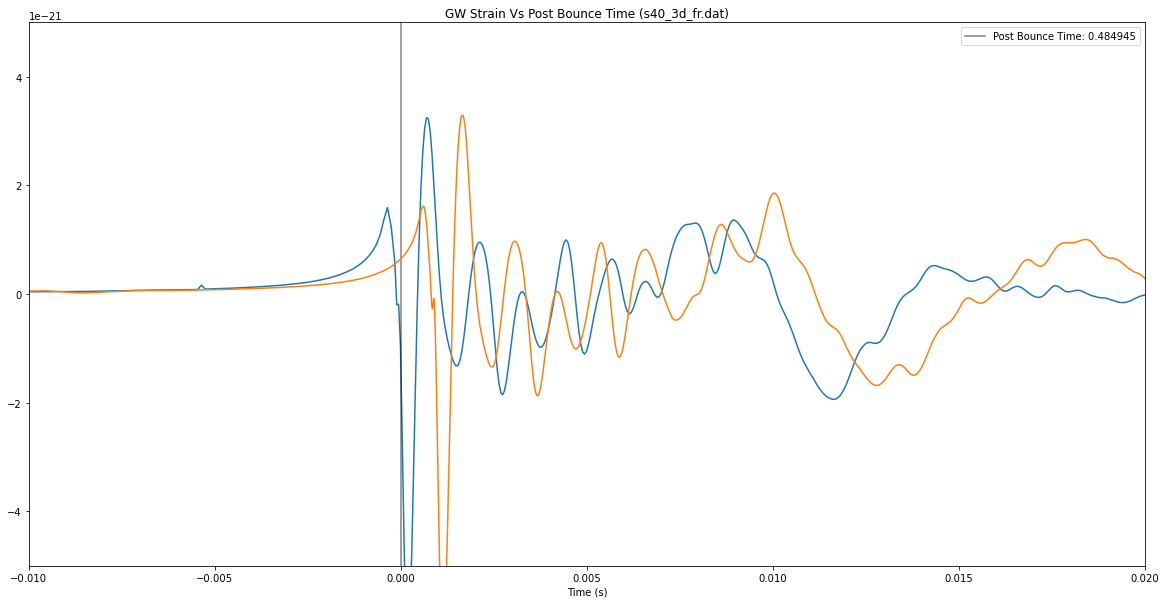

In [4]:
s40_fr.GW2dAnalysis(1,[20,10],[-0.010,0.020],[-0.5*1e-20, 0.5*1e-20])

In [ ]:
s40_sr.GW2dAnalysis(1,[20,10],[-0.011,0.020],[-0.15*1e-20, 0.15*1e-20])

In [ ]:
attachedDataFR = np.loadtxt('RawDataFiles/s40_sr_GW_short.txt')

fig, ax = plt.subplots(1)
fig.set_size_inches(20,10)

ax.plot(attachedDataFR[:,0], -attachedDataFR[:,1]) 

ax.set_xlabel('Time (s)')

## Max Viewing Angle 3d Scatter Plots

In [8]:
s40_fr.update_nVerts(80j)

blockTitle = 'Test Normalized, Maximum Gravitational Wave Strain (Data: '+'s40_3d_fr.'+') ('+'plus-polarized'+')'
s40_fr.maxStrainScatterPlot('Test_3DScatter_s40_cross_','AnimationRotateScatter/s40_3d_fr_MaxStrain_3dScatter/1Test/', 
                           'Test_3DScatter_s40_3d_fr_cross_', blockTitle, 0, norm = False, dataSlice=(-1,4))

#ffmpeg -framerate 10 -i Test_3DScatter_s40_cross_%04d.jpeg  Test_3DScatter_s40_3d_fr_cross_Movie.mp4

ffmpeg compilation string:
ffmpeg -framerate 10 -i Test_3DScatter_s40_cross_%04d.jpeg Test_3DScatter_s40_3d_fr_cross_Movie.mp4
